## Training with UCI Heart Disease Dataset
#### Dataset Info: https://archive.ics.uci.edu/dataset/45/heart+disease

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tab_transformer_pytorch import TabTransformer
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os

# fix random seed
torch.manual_seed(42)
np.random.seed(42)

# set device
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cuda


In [ ]:
# using ucimlrepo API to load data
from ucimlrepo import fetch_ucirepo
heart = fetch_ucirepo(id=45) # dataset id 45
df = heart.data.original.copy()

# cleaning missing values
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df["ca"] = pd.to_numeric(df["ca"])
df["thal"] = pd.to_numeric(df["thal"])
df["num"] = pd.to_numeric(df["num"])


In [ ]:
# sort categorical data and continuous data
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
continuous_cols = [col for col in df.columns if col not in categorical_cols + ['num']]

# Label encoding for categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# check dimensionality of categorical columns
category_dims = [df[col].nunique() for col in categorical_cols]
print("dimensionality of categorical columns：", category_dims)


In [ ]:
# train/test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['num'], random_state=42)

# build PyTorch Dataset and Dataloader
class HeartDataset(Dataset):
    def __init__(self, df):
        self.X_categ = torch.tensor(df[categorical_cols].astype('int64').values)
        self.X_cont = torch.tensor(df[continuous_cols].astype('float32').values)
        self.y = torch.tensor(df['num'].astype('int64').values)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_categ[idx], self.X_cont[idx], self.y[idx]

train_dataset = HeartDataset(train_df)
test_dataset = HeartDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
# initialize TabTransformer
model = TabTransformer(
    categories=category_dims,
    num_continuous=len(continuous_cols),
    dim=32,
    depth=4,
    heads=8,
    dim_out=5  # 5 classes
).to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# Train
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    for x_categ, x_cont, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x_categ, x_cont, y = x_categ.to(device), x_cont.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x_categ, x_cont)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1} - Loss: {running_loss:.4f} - Accuracy: {acc:.4f}")


Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  9.32it/s]


Epoch 1 - Loss: 6.4948 - Accuracy: 0.4557


Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 31.32it/s]


Epoch 2 - Loss: 3.9071 - Accuracy: 0.6245


Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 28.65it/s]


Epoch 3 - Loss: 3.3305 - Accuracy: 0.6540


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 28.11it/s]


Epoch 4 - Loss: 2.8976 - Accuracy: 0.6962


Epoch 5: 100%|██████████| 4/4 [00:00<00:00, 23.52it/s]


Epoch 5 - Loss: 2.5605 - Accuracy: 0.7468


Epoch 6: 100%|██████████| 4/4 [00:00<00:00, 31.14it/s]


Epoch 6 - Loss: 2.2270 - Accuracy: 0.7637


Epoch 7: 100%|██████████| 4/4 [00:00<00:00, 30.68it/s]


Epoch 7 - Loss: 1.9257 - Accuracy: 0.8059


Epoch 8: 100%|██████████| 4/4 [00:00<00:00, 32.32it/s]


Epoch 8 - Loss: 1.6966 - Accuracy: 0.8270


Epoch 9: 100%|██████████| 4/4 [00:00<00:00, 32.89it/s]


Epoch 9 - Loss: 1.4397 - Accuracy: 0.8608


Epoch 10: 100%|██████████| 4/4 [00:00<00:00, 33.19it/s]


Epoch 10 - Loss: 1.3724 - Accuracy: 0.8692


Epoch 11: 100%|██████████| 4/4 [00:00<00:00, 31.46it/s]


Epoch 11 - Loss: 1.2619 - Accuracy: 0.8650


Epoch 12: 100%|██████████| 4/4 [00:00<00:00, 32.24it/s]


Epoch 12 - Loss: 1.3028 - Accuracy: 0.8692


Epoch 13: 100%|██████████| 4/4 [00:00<00:00, 32.78it/s]


Epoch 13 - Loss: 1.2833 - Accuracy: 0.8523


Epoch 14: 100%|██████████| 4/4 [00:00<00:00, 32.42it/s]


Epoch 14 - Loss: 1.0674 - Accuracy: 0.8861


Epoch 15: 100%|██████████| 4/4 [00:00<00:00, 32.59it/s]


Epoch 15 - Loss: 1.2619 - Accuracy: 0.8776


Epoch 16: 100%|██████████| 4/4 [00:00<00:00, 29.41it/s]


Epoch 16 - Loss: 1.1396 - Accuracy: 0.8523


Epoch 17: 100%|██████████| 4/4 [00:00<00:00, 31.95it/s]


Epoch 17 - Loss: 1.3440 - Accuracy: 0.8650


Epoch 18: 100%|██████████| 4/4 [00:00<00:00, 31.14it/s]


Epoch 18 - Loss: 1.0092 - Accuracy: 0.8945


Epoch 19: 100%|██████████| 4/4 [00:00<00:00, 29.62it/s]


Epoch 19 - Loss: 1.2190 - Accuracy: 0.8692


Epoch 20: 100%|██████████| 4/4 [00:00<00:00, 31.83it/s]

Epoch 20 - Loss: 1.0783 - Accuracy: 0.8608


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.81      0.85        32
           1       0.24      0.36      0.29        11
           2       0.33      0.29      0.31         7
           3       0.29      0.29      0.29         7
           4       0.00      0.00      0.00         3

    accuracy                           0.57        60
   macro avg       0.35      0.35      0.35        60
weighted avg       0.59      0.57      0.58        60



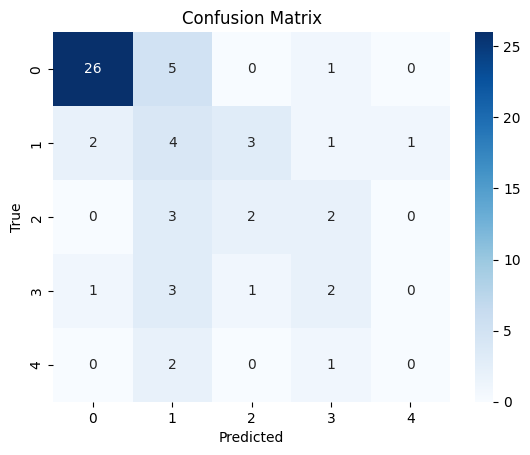

In [ ]:
# evaluation
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x_categ, x_cont, y in test_loader:
        x_categ, x_cont = x_categ.to(device), x_cont.to(device)
        logits = model(x_categ, x_cont)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y.numpy())

# Classification Report
print("Classification Report:\n")
print(classification_report(all_targets, all_preds))

# confusion matrix
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# save model checkpoints
torch.save(model.state_dict(), "tab_transformer_heart.pth")

In [ ]:
# check input data dimensions
tokens, features, labels = next(iter(train_loader))

print(f"Tokens shape: {tokens.shape}")
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"First token row: {tokens[0]}")
print(f"First feature row: {features[0]}")
print(f"First label: {labels[0]}")

Tokens shape: torch.Size([64, 8])
Features shape: torch.Size([64, 5])
Labels shape: torch.Size([64])
First token row: tensor([1, 3, 0, 0, 1, 1, 2, 2])
First feature row: tensor([ 62.0000, 120.0000, 267.0000,  99.0000,   1.8000])
First label: 1


## Full-Parameters Fine Tuning with AMD Tabular Demographic Dataset
#### Dataset: annotation_modified_final_forTrain

C:\Users\User\AppData\Local\Temp\ipykernel_30704\4251308385.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amd_df[col] = le.fit_transform(amd_df[col].astype(str))
C:\Users\User\AppData\Local\Temp\ipykernel_30704\4251308385.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amd_df[col] = le.fit_transform(amd_df[col].astype(str))
C:\Users\User\AppData\Local\Temp\ipykernel_30704\4251308385.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Epoch 1 - Loss: 12.6319 - Accuracy: 0.2800


Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 41.06it/s]


Epoch 2 - Loss: 5.3918 - Accuracy: 0.2667


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 42.00it/s]


Epoch 3 - Loss: 4.3300 - Accuracy: 0.4400


Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 42.24it/s]


Epoch 4 - Loss: 3.9484 - Accuracy: 0.4400


Epoch 5: 100%|██████████| 3/3 [00:00<00:00, 43.16it/s]


Epoch 5 - Loss: 3.4938 - Accuracy: 0.6000


Epoch 6: 100%|██████████| 3/3 [00:00<00:00, 45.45it/s]


Epoch 6 - Loss: 3.0482 - Accuracy: 0.6267


Epoch 7: 100%|██████████| 3/3 [00:00<00:00, 44.44it/s]


Epoch 7 - Loss: 2.5259 - Accuracy: 0.6400


Epoch 8: 100%|██████████| 3/3 [00:00<00:00, 46.50it/s]


Epoch 8 - Loss: 1.9892 - Accuracy: 0.7733


Epoch 9: 100%|██████████| 3/3 [00:00<00:00, 45.45it/s]


Epoch 9 - Loss: 1.7762 - Accuracy: 0.7733


Epoch 10: 100%|██████████| 3/3 [00:00<00:00, 44.10it/s]


Epoch 10 - Loss: 1.7002 - Accuracy: 0.8400


Epoch 11: 100%|██████████| 3/3 [00:00<00:00, 44.09it/s]


Epoch 11 - Loss: 1.4577 - Accuracy: 0.8667


Epoch 12: 100%|██████████| 3/3 [00:00<00:00, 42.59it/s]


Epoch 12 - Loss: 0.7826 - Accuracy: 0.9200


Epoch 13: 100%|██████████| 3/3 [00:00<00:00, 46.50it/s]


Epoch 13 - Loss: 0.8918 - Accuracy: 0.8933


Epoch 14: 100%|██████████| 3/3 [00:00<00:00, 43.13it/s]


Epoch 14 - Loss: 0.6775 - Accuracy: 0.9067


Epoch 15: 100%|██████████| 3/3 [00:00<00:00, 41.95it/s]


Epoch 15 - Loss: 0.5800 - Accuracy: 0.9067


Epoch 16: 100%|██████████| 3/3 [00:00<00:00, 34.92it/s]


Epoch 16 - Loss: 0.4624 - Accuracy: 0.9200


Epoch 17: 100%|██████████| 3/3 [00:00<00:00, 45.45it/s]


Epoch 17 - Loss: 0.4234 - Accuracy: 0.9333


Epoch 18: 100%|██████████| 3/3 [00:00<00:00, 44.41it/s]


Epoch 18 - Loss: 0.3896 - Accuracy: 0.9333


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 46.50it/s]


Epoch 19 - Loss: 0.3291 - Accuracy: 0.9200


Epoch 20: 100%|██████████| 3/3 [00:00<00:00, 42.20it/s]


Epoch 20 - Loss: 0.3602 - Accuracy: 0.9067
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.20      0.25      0.22         4
           3       0.00      0.00      0.00         0
           4       0.40      0.50      0.44         4
           5       0.00      0.00      0.00         7

    accuracy                           0.16        19
   macro avg       0.10      0.12      0.11        19
weighted avg       0.13      0.16      0.14        19



c:\Users\User\anaconda3\envs\tabtransformer-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\tabtransformer-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\tabtransformer-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

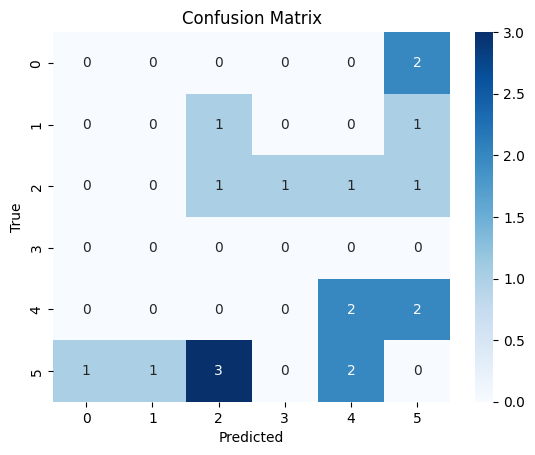

In [ ]:
# === import libraries ===
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tab_transformer_pytorch import TabTransformer
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === select features ===
categorical_cols_amd = [
    'Laterality','SEX', 'CIGARETTES_YN', 'SMOKING_TOB_USE_NAME',
       'SMOKELESS_TOB_USE_NAME', 'TOBACCO_USER_NAME', 'ALCOHOL_USE_NAME',
       'ILL_DRUG_USER_NAME', 'VA (Closest to Dx)', 'PRIMARY_DX_YN'
    #    'DX_NAME', 'CURRENT_ICD10_LIST', # string format data needs additional encoding method, so I didn't pick them for now.
       
]
continuous_cols_amd = [
    'BIRTH_YEAR', 'BIRTH_MONTH', 'BIRTH_DAY',  # birthday'
       'VISION_YEAR', 'VISION_MONTH', 'VISION_DAY', # VA date
       'DIAGNOSIS_YEAR', 'DIAGNOSIS_MONTH', 'DIAGNOSIS_DAY'# Diagnosis date
] 

label_col = 'Diagnosis Label' 

# drop missing values
df = pd.read_excel("annotation_modified_final_forTrain.xlsx")
amd_df = df.dropna(subset=categorical_cols_amd + continuous_cols_amd + [label_col])

# encode categorical data
encoders = {}
for col in categorical_cols_amd + [label_col]:
    le = LabelEncoder()
    amd_df[col] = le.fit_transform(amd_df[col].astype(str))
    encoders[col] = le

# train/test split
train_df, test_df = train_test_split(amd_df, test_size=0.2, stratify=amd_df[label_col], random_state=42)

# check dimensionality of categorical columns
category_dims_amd = [train_df[col].nunique() for col in categorical_cols_amd]

# === build Dataset and DataLoader ===
class AMDDataset(Dataset):
    def __init__(self, df):
        self.X_categ = torch.tensor(df[categorical_cols_amd].values, dtype=torch.long)
        self.X_cont = torch.tensor(df[continuous_cols_amd].values, dtype=torch.float32)
        self.y = torch.tensor(df[label_col].values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_categ[idx], self.X_cont[idx], self.y[idx]

train_dataset = AMDDataset(train_df)
test_dataset = AMDDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# === initialize TabTransformer ===
model = TabTransformer(
    categories=category_dims_amd,
    num_continuous=len(continuous_cols_amd),
    dim=32,
    depth=4,
    heads=8,
    dim_out=amd_df[label_col].nunique() # 6 classes
).to(device)

# === Load pretrained TabTransformer weights only encoder ===
pretrained_dict = torch.load("tab_transformer_heart.pth", map_location=device)
transformer_weights = {k: v for k, v in pretrained_dict.items() if k.startswith("transformer.")}
model.load_state_dict(transformer_weights, strict=False)

# === Loss & Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === fine-tuning ===
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for x_categ, x_cont, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x_categ, x_cont, y = x_categ.to(device), x_cont.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x_categ, x_cont)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    acc = correct / total
    print(f"Epoch {epoch+1} - Loss: {running_loss:.4f} - Accuracy: {acc:.4f}")

# === evaluation ===
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for x_categ, x_cont, y in test_loader:
        x_categ, x_cont = x_categ.to(device), x_cont.to(device)
        logits = model(x_categ, x_cont)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y.numpy())

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(all_targets, all_preds))

# 混淆矩陣
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
torch.save(model.state_dict(), "tab_transformer_amd_finetuned.pth")

## Freeze Encoder Fine Tuning with AMD Tabular Demographic Dataset

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tab_transformer_pytorch import TabTransformer
from tqdm import tqdm

# === 預處理 ===
amd_df = pd.read_excel("annotation_modified_final_forTrain.xlsx")
amd_df.dropna(subset=['Diagnosis Label'], inplace=True)


# 特徵欄位
categorical_cols_amd = [
    'Laterality','SEX', 'CIGARETTES_YN', 'SMOKING_TOB_USE_NAME',
    'SMOKELESS_TOB_USE_NAME', 'TOBACCO_USER_NAME', 'ALCOHOL_USE_NAME',
    'ILL_DRUG_USER_NAME', 'VA (Closest to Dx)', 'PRIMARY_DX_YN'
]
continuous_cols_amd = [
    'BIRTH_YEAR', 'BIRTH_MONTH', 'BIRTH_DAY', 
    'VISION_YEAR', 'VISION_MONTH', 'VISION_DAY',
    'DIAGNOSIS_YEAR', 'DIAGNOSIS_MONTH', 'DIAGNOSIS_DAY'
]
label_col = 'Diagnosis Label'

# label encoding
le = LabelEncoder()
amd_df[label_col] = le.fit_transform(amd_df[label_col])

# 類別欄位 label encoding
for col in categorical_cols_amd:
    amd_df[col] = LabelEncoder().fit_transform(amd_df[col].astype(str))

# 資料切分
train_df, test_df = train_test_split(amd_df, test_size=0.2, stratify=amd_df[label_col], random_state=42)

# Dataset class
class AMDDataset(Dataset):
    def __init__(self, df):
        self.X_categ = torch.tensor(df[categorical_cols_amd].values, dtype=torch.long)
        self.X_cont = torch.tensor(df[continuous_cols_amd].values, dtype=torch.float32)
        self.y = torch.tensor(df[label_col].values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_categ[idx], self.X_cont[idx], self.y[idx]

train_dataset = AMDDataset(train_df)
test_dataset = AMDDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 模型初始化
category_dims_amd = [amd_df[col].nunique() for col in categorical_cols_amd]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TabTransformer(
    categories=category_dims_amd,
    num_continuous=len(continuous_cols_amd),
    dim=32,
    depth=4,
    heads=8,
    dim_out=amd_df[label_col].nunique()
).to(device)

# 載入預訓練權重（忽略 MLP 大小不符）
# state_dict = torch.load("tab_transformer_heart.pth", map_location=device)
# model.load_state_dict(state_dict, strict=False)
pretrained_dict = torch.load("tab_transformer_heart.pth", map_location=device)
transformer_weights = {k: v for k, v in pretrained_dict.items() if k.startswith("transformer.")}
model.load_state_dict(transformer_weights, strict=False)

# ❄️ Freeze Transformer 部分
for param in model.transformer.parameters():
    param.requires_grad = False

# 可以選擇也 freeze embedding
# for param in model.category_embed.parameters():
#     param.requires_grad = False

# 定義 loss 與 optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-7)

# 訓練 loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    for x_categ, x_cont, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x_categ, x_cont, y = x_categ.to(device), x_cont.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x_categ, x_cont)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f} - Accuracy: {correct / total:.4f}")

# 測試評估
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for x_categ, x_cont, y in test_loader:
        x_categ, x_cont = x_categ.to(device), x_cont.to(device)
        logits = model(x_categ, x_cont)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y.numpy())

print(classification_report(all_targets, all_preds, target_names=le.classes_))


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 15.33it/s]


Epoch 1 - Loss: nan - Accuracy: 0.1522


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 50.88it/s]


Epoch 2 - Loss: nan - Accuracy: 0.1594


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 52.03it/s]


Epoch 3 - Loss: nan - Accuracy: 0.1594


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 50.59it/s]


Epoch 4 - Loss: nan - Accuracy: 0.1594


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 52.67it/s]


Epoch 5 - Loss: nan - Accuracy: 0.1594


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 55.49it/s]


Epoch 6 - Loss: nan - Accuracy: 0.1594


Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 50.22it/s]


Epoch 7 - Loss: nan - Accuracy: 0.1594


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 53.51it/s]


Epoch 8 - Loss: nan - Accuracy: 0.1594


Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 51.78it/s]


Epoch 9 - Loss: nan - Accuracy: 0.1594


Epoch 10: 100%|██████████| 5/5 [00:00<00:00, 52.56it/s]


Epoch 10 - Loss: nan - Accuracy: 0.1594


Epoch 11: 100%|██████████| 5/5 [00:00<00:00, 52.86it/s]


Epoch 11 - Loss: nan - Accuracy: 0.1594


Epoch 12: 100%|██████████| 5/5 [00:00<00:00, 51.76it/s]


Epoch 12 - Loss: nan - Accuracy: 0.1594


Epoch 13: 100%|██████████| 5/5 [00:00<00:00, 53.88it/s]


Epoch 13 - Loss: nan - Accuracy: 0.1594


Epoch 14: 100%|██████████| 5/5 [00:00<00:00, 54.57it/s]


Epoch 14 - Loss: nan - Accuracy: 0.1594


Epoch 15: 100%|██████████| 5/5 [00:00<00:00, 47.83it/s]


Epoch 15 - Loss: nan - Accuracy: 0.1594


Epoch 16: 100%|██████████| 5/5 [00:00<00:00, 52.33it/s]


Epoch 16 - Loss: nan - Accuracy: 0.1594


Epoch 17: 100%|██████████| 5/5 [00:00<00:00, 50.21it/s]


Epoch 17 - Loss: nan - Accuracy: 0.1594


Epoch 18: 100%|██████████| 5/5 [00:00<00:00, 46.05it/s]


Epoch 18 - Loss: nan - Accuracy: 0.1594


Epoch 19: 100%|██████████| 5/5 [00:00<00:00, 52.28it/s]


Epoch 19 - Loss: nan - Accuracy: 0.1594


Epoch 20: 100%|██████████| 5/5 [00:00<00:00, 44.81it/s]

Epoch 20 - Loss: nan - Accuracy: 0.1594
              precision    recall  f1-score   support

   Early AMD       0.17      1.00      0.29         6
          GA       0.00      0.00      0.00         4
     Int AMD       0.00      0.00      0.00         7
     Not AMD       0.00      0.00      0.00         1
        Scar       0.00      0.00      0.00         5
         Wet       0.00      0.00      0.00        12

    accuracy                           0.17        35
   macro avg       0.03      0.17      0.05        35
weighted avg       0.03      0.17      0.05        35




c:\Users\User\anaconda3\envs\tabtransformer-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\tabtransformer-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\tabtransformer-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca